In [6]:
from arch.bootstrap import CircularBlockBootstrap, optimal_block_length
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import log
from scipy.stats import boxcox

In [7]:
with open('low_var_port.pkl', 'rb') as f: d = pickle.load(f)

In [24]:
###Function returns list of days between dividend payouts
###Input is series of dividend returns.

def days_between_div(dividend_returns):
    ls_div_days_between = []
    div_cnt = 1
    y = np.array(dividend_returns).T
    for x in y:
        if np.isclose(0, x):
            div_cnt += 1
        else:
            ls_div_days_between.append(div_cnt)
            div_cnt = 1
    return ls_div_days_between

###Function returns list of dividend dates
###Input is series of dividend returns.

def div_dates(dividend_returns):
    div_dates = dividend_returns[dividend_returns > 0].index
    return div_dates


###Function returns an average return for a period, and standard deviation of returns for a period, list of dividend returns for a period
###Input are:
###         ls_div  - the days between returns 
###         returns - dataframe of dividend returns (labeled 'retd') and daily returns (labeled 'retx').

def div_to_div_metrics(ls_div_days_between, returns):

    div_day_cumsum = np.cumsum(ls_div_days_between)
    start = 1
    cumret = 0
    ls_div_to_div_ret = []
    ls_div_ret = []
    ls_div_to_div_std = []

    for x in div_day_cumsum:
        div_to_div_std = np.std((np.array(returns.iloc[start-1:x-1]['retx'])))
        div_to_div_ret = (np.array(returns.iloc[start-1:x-1]['retx'])).prod()
        div = (returns.iloc[x-1]['retd'])
        ls_div_to_div_std.append(div_to_div_std)
        ls_div_to_div_ret.append(div_to_div_ret)
        ls_div_ret.append(div)
        start=x
    return ls_div_to_div_ret, ls_div_to_div_std, ls_div_ret

###Function returns a sklearn linear regression model to predict the dividend returns.
###Input are:
###         ls_div_to_div_ret  - list of daily returns between dividends
###         ls_div_to_div_std - list of std between dividends
###         ls_div_ret - List of dividend returns between dividends

def div_predict_linreg(ls_div_to_div_ret,ls_div_to_div_std, ls_div_ret):
    X = np.array([ls_div_to_div_ret,ls_div_to_div_std]).T
    y=ls_div_ret
    reg = LinearRegression().fit(X,y)
    return reg

###Function returns an (days of returns, 3, total_sim) array that provides a block bootstrap simulation of an assets price, daily returns and dividend returns.
###Input are:
###         data  - dataframe of price ('prc'), daily returns ('retx'), and dividend returns'retd' over a period time
###         ls_div_days_between - provides the number of days between dividend payouts
###         block_size - size of the blocks that are taken from the original dataframe
###         total_sim - number of samples to run
###         random_seed - seed to use for block bootstrap

def sim_returns(data, block_size = 20, total_sim = 10, random_seed = 1):
    retx_sim = data[data['retd'] == 0]['retx']
    rs = np.random.RandomState(random_seed)
    retx_sim_mod = CircularBlockBootstrap(20, retx_sim, random_state = rs)
    sim = np.zeros((total_sim,len(data), 3))
    count = 0
    if len(retx_sim) == len(data):
        for y in retx_sim_mod.bootstrap(total_sim):
            
            ls_retx = y[0][0]
            ls_retx.index = retx_sim.index
            ls_retx = ls_retx.sort_index()
            ls_retx[0] = 1
            prc = ls_retx*0
            prc[0] = data.prc[0]
            cum_retx_all = ls_retx[1:].cumprod()
            prc[1:] = cum_retx_all * prc[0]
            div_pay = ls_retx*0
            sim[count,:,:] = np.array([prc,ls_retx,div_pay]).T
            count +=1
    else:      
        ls_div_days_between = days_between_div(data['retd'])
        div_day_cumsum = np.cumsum(ls_div_days_between)
        ls_div_dt = div_dates(data['retd'])
        ls_div_to_div_ret, ls_div_to_div_std, ls_div_ret = div_to_div_metrics(ls_div_days_between, data)
        reg = div_predict_linreg(ls_div_to_div_ret,ls_div_to_div_std, ls_div_ret)
        for y in retx_sim_mod.bootstrap(total_sim):
            ls_retx = y[0][0]
            ls_of_div = np.array(data[data['retd'] != 0]['retd'])
            ls_of_div_retx = np.array(data[data['retd'] != 0]['retx'])
            ls_sim_div = []
            ls_retx.index = retx_sim.index
            start = 1
            for x in range(len(div_day_cumsum)):
                cum_retx = np.array(ls_retx[start-1:div_day_cumsum[x]-1]).prod()
                cum_std = np.array(ls_retx[start-1:div_day_cumsum[x]-1]).std()
                pred_div = reg.predict(np.array([[cum_retx],[cum_std]]).T)
                sim_div_idx = min(ls_of_div, key=lambda i:abs(i-pred_div[0]))
                sim_rx = ls_of_div_retx[np.where(ls_of_div==sim_div_idx)[0][0]]
                ls_retx.loc[ls_div_dt[x]] = sim_rx
                ls_sim_div.append(pred_div[0])
                
            ls_retx = ls_retx.sort_index()
            ls_retx[0] = 1
            prc = ls_retx*0
            prc[0] = data.prc[0]
            cum_retx_all = ls_retx[1:].cumprod()
            prc[1:] = cum_retx_all * prc[0]
            div_pay = ls_retx*0
            div_dic = dict(zip(ls_div_dt, ls_sim_div)) 
            for i in ls_div_dt:
                div_pay[i] = div_dic[i]

            sim[count,:,:] = np.array([prc,ls_retx,div_pay]).T
            count +=1
    return sim

In [25]:
###Function returns an (days of returns, (3*# of assets), total_sim) array that provides a block bootstrap simulation of all assets price, daily returns and dividend returns.
###Input are:
###         data  - dataframe of assets with price ('prc'), daily returns ('retx'), and dividend returns ('retd') over a period time. Dataframe must have hierarchical format of Asset -> [prc, retx, retd].
###         ls_div_days_between - provides the number of days between dividend payouts
###         block_size - size of the blocks that are taken from the original dataframe
###         total_sim - number of samples to run
###         random_seed - seed to use for block bootstrap

def sim_all(data, block_size = 20, total_sim = 10, random_seed = 1):
    tickers = []
    for x in data.columns:
        if x[0] not in tickers:
            tickers.append(x[0])
    ticker_sim = {}
    for tck in tickers:
        asset_data = data[tck]
        tck_sim = sim_returns(asset_data, block_size = block_size, total_sim = total_sim, random_seed = random_seed)
        ticker_sim[tck] = tck_sim
    return ticker_sim

In [26]:
sim_all(d)

{'SPY': array([[[1.17419998e+02, 1.00000000e+00, 0.00000000e+00],
         [1.17624792e+02, 1.00174412e+00, 0.00000000e+00],
         [1.16242381e+02, 9.88247278e-01, 0.00000000e+00],
         ...,
         [4.21542627e+02, 9.93908933e-01, 0.00000000e+00],
         [4.24159608e+02, 1.00620811e+00, 0.00000000e+00],
         [4.29601842e+02, 1.01283063e+00, 0.00000000e+00]],
 
        [[1.17419998e+02, 1.00000000e+00, 0.00000000e+00],
         [1.18555760e+02, 1.00967264e+00, 0.00000000e+00],
         [1.18363553e+02, 9.98378768e-01, 0.00000000e+00],
         ...,
         [1.72675302e+03, 9.99619489e-01, 0.00000000e+00],
         [1.74187452e+03, 1.00875719e+00, 0.00000000e+00],
         [1.74463574e+03, 1.00158520e+00, 0.00000000e+00]],
 
        [[1.17419998e+02, 1.00000000e+00, 0.00000000e+00],
         [1.17899426e+02, 1.00408302e+00, 0.00000000e+00],
         [1.18740465e+02, 1.00713353e+00, 0.00000000e+00],
         ...,
         [4.35527983e+02, 9.97333174e-01, 0.00000000e+00],
 

In [8]:
len(d)

4035

In [10]:
###retd is correlated to both returns and variance in a period

x = ls_div_to_div_std
y = ls_div_ret
plt.scatter(x, y)

NameError: name 'ls_div_to_div_std' is not defined

In [11]:
x = ls_div_to_div_ret
y = ls_div_ret
plt.scatter(x, y)

NameError: name 'ls_div_to_div_ret' is not defined

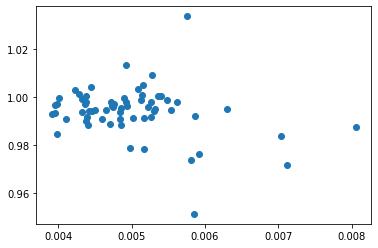

In [12]:
###Price the day of a return is very slightly correlated to the dividend price, but has a loss on average.

plt.scatter(np.array(d[d['SPY']['retd'] != 0]['SPY']['retd']), np.array(d[d['SPY']['retd'] != 0]['SPY']['retx']))

In [13]:
np.corrcoef(np.array(d[d['SPY']['retd'] != 0]['SPY']['retd']), np.array(d[d['SPY']['retd'] != 0]['SPY']['retx']))

array([[ 1.        , -0.25238551],
       [-0.25238551,  1.        ]])

In [14]:
d[d['SPY']['retd'] != 0]['SPY']['retx'].mean()

0.9942439051728797

In [15]:
np.array(d[d['SPY']['retd'] != 0]['SPY']['retx']).std()

0.01044219807136065

In [16]:
s_ls_div = []
t_ls_div = []
s_div_cnt = 1
t_div_cnt = 1
for x in d.iterrows():
    if x[1]['SPY']['retd'] == 0:
        s_div_cnt += 1
    else:
        s_ls_div.append(s_div_cnt)
        s_div_cnt = 1
    if x[1]['TLT']['retd'] == 0:
        t_div_cnt += 1
    else:
        t_ls_div.append(t_div_cnt)
        t_div_cnt = 1    

In [17]:
s_ls_div_dt = []
t_ls_div_dt = []
s_div_cnt = 0
t_div_cnt = 0
for x in d.iterrows():
    if x[1]['SPY']['retd'] != 0:
        s_ls_div_dt.append(x[0])
    if x[1]['TLT']['retd'] != 0:
        t_ls_div_dt.append(x[0])


In [18]:
###This is to get the dividends to create a model for predicting/simulating retd

div_day_cumsum = np.cumsum(s_ls_div)
start = 1
cumret = 0
ls_div_to_div_ret = []
ls_div_ret = []
ls_div_to_div_std = []

for x in div_day_cumsum:
    div_to_div_std = np.std((np.array(d.iloc[start-1:x-1]['SPY']['ret'])))
    div_to_div_ret = (np.array(d.iloc[start-1:x-1]['SPY']['ret'])).prod()
    spy_div = (d.iloc[x-1]['SPY']['retd'])
    ls_div_to_div_std.append(div_to_div_std)
    ls_div_to_div_ret.append(div_to_div_ret)
    ls_div_ret.append(spy_div)
    start=x
    
X = np.array([ls_div_to_div_ret,ls_div_to_div_std]).T
y=ls_div_ret
reg = LinearRegression().fit(X,y)



In [19]:
###This simulates the retx, and uses that simulate price and dividend.



retx_sim = d[d['SPY']['retd'] == 0]['SPY']['retx']
retx_sim_mod = CircularBlockBootstrap(20, retx_sim)
tot_sim = 10
sim = np.zeros((tot_sim,4035, 3))
count = 0
prc = []
for y in retx_sim_mod.bootstrap(tot_sim):
    test = y[0][0]



    div_day_cumsum = np.cumsum(s_ls_div)
    start = 1
    ls_of_div = np.array(d[d['SPY']['retd'] != 0]['SPY']['retd'])
    ls_of_div_retx = np.array(d[d['SPY']['retd'] != 0]['SPY']['retx'])

    ls_sim_div = []

    test.index = retx_sim.index
    for x in range(len(div_day_cumsum)):
        cum_retx = np.array(test[start-1:div_day_cumsum[x]-1]).prod()
        cum_std = np.array(test[start-1:div_day_cumsum[x]-1]).std()
        pred_div = reg.predict(np.array([[cum_retx],[cum_std]]).T)
        sim_div_idx = min(ls_of_div, key=lambda i:abs(i-pred_div))
        sim_rx = ls_of_div_retx[np.where(ls_of_div==sim_div_idx)[0][0]]
        test.loc[s_ls_div_dt[x]] = sim_rx
        ls_sim_div.append(pred_div[0])
        test = test.sort_index()
        start=div_day_cumsum[x]

    test[0] = 1
    prc = test
    prc[0] = d.SPY.prc[0]
    prc[1:] = test[1:].cumprod() * prc[0]



    div_pay = test*0
    div_dic = dict(zip(s_ls_div_dt, ls_sim_div)) 
    for i in s_ls_div_dt:
        div_pay[i] = div_dic[i]

    sim[count,:,:] = np.array((prc,test,div_pay)).T
    count +=1
    
    
